In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}


In [3]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [4]:
from typing import Any


class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True) 
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) 
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
  
class Embedding:
  def __init__(self, num_embeddings, embbedding_dim):
    self.weight = torch.randn((num_embeddings, embbedding_dim))
    
  def __call__(self, x):
    self.out = self.weight[x]
    return self.out
  
  
  def parameters(self):
    return [self.weight]
  
  
class Flatten:
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
    
  def parameters(self):
    return []


class Sequential:
  
  def __init__(self, layers) -> None:
    self.layers = layers
    
  def __call__(self, x) -> Any:
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [5]:
n_embed = 10
n_hidden = 200

model = Sequential([Embedding(vocab_size ,n_embed),
          Flatten(),
          Linear(n_embed*block_size, n_hidden, bias=False),
          BatchNorm1d(n_hidden), 
          Tanh(), 
          Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1


parameters = model.parameters()
for p in parameters:
    p.requires_grad = True


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: 
    print(f'{i:7d} step: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0 step: 3.2872
  10000 step: 2.1818
  20000 step: 2.2796
  30000 step: 2.1644
  40000 step: 2.0120
  50000 step: 1.7750
  60000 step: 2.4177
  70000 step: 2.1978
  80000 step: 1.9695
  90000 step: 2.1769
 100000 step: 2.5491
 110000 step: 2.4792
 120000 step: 1.9749
 130000 step: 2.4204
 140000 step: 2.3306
 150000 step: 2.3567
 160000 step: 2.1873
 170000 step: 2.3091
 180000 step: 2.3609
 190000 step: 2.1352


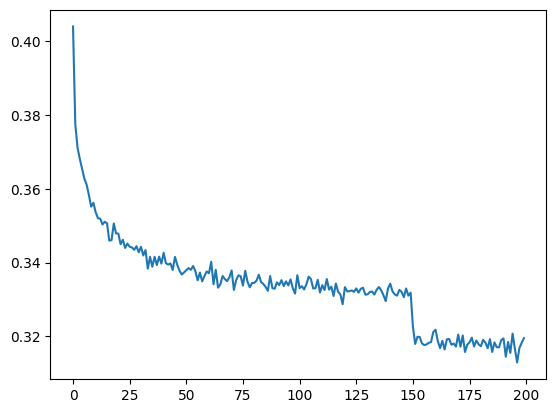

In [7]:
plt.plot(torch.tensor([lossi]).view(-1, 1000).mean(dim=1, keepdim=True))


In [8]:
for layer in model.layers:
    layer.training = False 

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr),
            "eval": (Xdev, Ydev), 
            "test": (Xte, Yte)}[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(loss.item())
    
split_loss("train")
split_loss("eval")

2.0585105419158936
2.1097218990325928


In [10]:
for _ in range(20):
    
    out = []
    context = [0]*block_size
    while True:
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix==0:
            break
    print( ''.join(itos[i] for i in out))
        

chrisparlowanio.
ima.
ika.
mallicenayven.
ilo.
makeem.
rahianna.
jele.
jroeqianso.
kinn.
alanitri.
shayvio.
adency.
makaria.
gradyn.
lyriann.
kenna.
dan.
jorden.
pag.
